Text(0, 0.5, 'sigmoid(z) ')

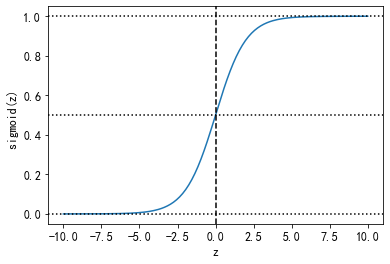

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 12
# 定义sigmoid函数。
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
z = np.linspace(-10, 10, 200)
plt.plot(z, sigmoid(z))
# 绘制水平线与垂直线。
plt.axvline(x=0, ls="--", c="k")
plt.axhline(ls=":", c="k")
plt.axhline(y=0.5, ls=":", c="k")
plt.axhline(y=1, ls=":", c="k")
plt.xlabel("z")
plt.ylabel("sigmoid(z) ")


# 地址要素解析比赛

## （1）赛题描述
中文地址要素解析任务的目标即将一条地址分解为上述几个部分的详细标签，如：

输入：浙江省杭州市余杭区五常街道文一西路969号淘宝城5号楼，放前台

输出：Province=浙江省 city=杭州市 district=余杭区 town=五常街道 road=文一西路road_number=969号 poi=淘宝城 house_number=5号楼 other=，放前台

## （2）数据说明
标注数据集由训练集、验证集和测试集组成，整体标注数据大约2万条左右。地址数据通过抓取公开的地址信息（如黄页网站等）获得， 均通过众包标注生成，详细标注规范将会在数据发布时一并给出。

## （3）命名实体识别介绍
命名实体识别是NLP中一项非常基础的任务，是信息提取、问答系统、句法分析、机器翻译等众多NLP任务的重要基础工具。命名实体识别的准确度，决定了下游任务的效果，是NLP中的一个基础问题。在NER任务提供了两种解决方案，一类LSTM/GRU + CRF，RNN类的模型来抽取底层文本的信息，而CRF(条件随机场)模型来学习底层Token之间的联系；另外一类是通过预训练模型，例如ERNIE，BERT模型，直接来预测Token的标签信息。本文采用两者结合的方法。

本项目将演示，如何使用从快递单中抽取姓名、电话、省、市、区、详细地址等内容，形成结构化信息。辅助物流行业从业者进行有效信息的提取，从而降低客户填单的成本，完成比赛。


In [3]:
#安装paddlenlp2.0
#!pip install paddlenlp


Could not fetch URL https://pypi.org/simple/paddlenlp/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/paddlenlp/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1125)'))) - skipping


ERROR: Could not find a version that satisfies the requirement paddlenlp (from versions: none)
ERROR: No matching distribution found for paddlenlp


# 1、导入必要的模块

In [1]:
import paddle
import paddlenlp as ppnlp
from paddlenlp.datasets import MapDataset
from paddlenlp.data import Stack, Pad, Tuple
from paddlenlp.metrics import ChunkEvaluator
import paddle.nn.functional as F
import numpy as np
from functools import partial #partial()函数可以用来固定某些参数值，并返回一个新的callable对象
import pdb

# 2、数据查看

In [ ]:
!head -n10 dataset/train.conll

In [ ]:
!head -n10  dataset/dev.conll

In [ ]:
!head dataset/final_test.txt

# 3、数据格式调整，将原先每行是每个字的标注形式，修改为每行是每句话的标注形式，相邻字（标注）之间，采用符号'\002'进行分隔

In [ ]:
import os
#对文件source_filename的数据格式进行调整，结果保存在文件target_filename中
def format_data(source_filename, target_filename):
    #pdb.set_trace()
    #结果列表初始化为空
    datalist=[]
    #读取source_filename所有数据到lines中，每个元素是字标注
    with open(source_filename, 'r', encoding='utf-8') as f:
        lines=f.readlines()
    words=''
    labels=''
    #当前处理的是否为每句话首字符，0：是，1：不是
    flag=0
    #逐个处理每个字标注
    for line in lines:
        #空行表示每句话标注的结束
        if line == '\n':
            #连接文本和标注结果
            item=words+'\t'+labels+'\n'
            #print(item)
            #添加到结果列表中
            datalist.append(item)
            #重置文本和标注结果
            words=''
            labels=''
            flag=0
            continue
        #pdb.set_trace()
        #分离出字和标注
        word, label = line.strip('\n').split(' ')
        #不是每句话的首字符
        if flag==1:
            #words/labels非空，和字/标签连接时需要添加分隔符'\002'
            words=words+'\002'+word
            labels=labels+'\002'+label
        else:#每句话首字符，words/labels为空，和字/标签连接时不需要添加分隔符'\002'
            words=words+word
            labels=labels+label
            flag=1#修改标志
    with open(target_filename, 'w', encoding='utf-8') as f:
        #pdb.set_trace()
        #将转换结果写入文件target_filename
        lines=f.writelines(datalist)
    print(f'{source_filename}文件格式转换完毕，保存为{target_filename}')

In [ ]:
#逐个转换文件
format_data('./dataset/dev.conll', './dataset/dev.txt')
format_data(r'./dataset/train.conll', r'./dataset/train.txt')

In [ ]:
!head dataset/dev.txt

# 4、构建Label标签表

In [ ]:
#提取文件source_filename1和source_filename2的标签类型，保存到target_filename
def gernate_dic(source_filename1, source_filename2, target_filename):
    #标签类型列表初始化为空
    data_list=[]

    #读取source_filename1所有行到lines中，每行元素是单字和标注
    with open(source_filename1, 'r', encoding='utf-8') as f:
        lines=f.readlines()

    #处理每行数据（单字+‘ ’+标注）
    for line in lines:
        #数据非空
        if line != '\n':
            #提取标注，-1是数组最后1个元素
            dic=line.strip('\n').split(' ')[-1]
            #不在标签类型列表中，则添加
            if dic+'\n' not in data_list:
                data_list.append(dic+'\n')
    
    #读取source_filename2所有行到lines中，每行元素是单字和标注
    with open(source_filename2, 'r', encoding='utf-8') as f:
        lines=f.readlines()

    #处理每行数据（单字+‘ ’+标注）
    for line in lines:
        #数据非空
        if line != '\n':
            #提取标注，-1是数组最后1个元素
            dic=line.strip('\n').split(' ')[-1]
            #不在标签类型列表中，则添加
            if dic+'\n' not in data_list:
                data_list.append(dic+'\n')

    with open(target_filename, 'w', encoding='utf-8') as f:
        #将标签类型列表写入文件target_filename
        lines=f.writelines(data_list)

In [ ]:
# 根据训练集和验证集生成dic，保存所有的标签
gernate_dic('dataset/train.conll', 'dataset/dev.conll', 'dataset/mytag.dic')
# 查看生成的dic文件
!cat dataset/mytag.dic

# 5、加载自定义数据集

In [ ]:
#加载数据文件datafiles
def load_dataset(datafiles):
    #读取数据文件data_path
    def read(data_path):
        with open(data_path, 'r', encoding='utf-8') as fp:
            next(fp)  # Skip header  #Deleted by WGM
            #处理每行数据（文本+‘\t’+标注）
            for line in fp.readlines():
                #提取文本和标注
                words, labels = line.strip('\n').split('\t')
                #文本中单字和标注构成的数组
                words = words.split('\002')
                labels = labels.split('\002')
                #迭代返回文本和标注
                yield words, labels
    
    #根据datafiles的数据类型，选择合适的处理方式
    if isinstance(datafiles, str):#字符串，单个文件名称
        #返回单个文件对应的单个数据集
        return MapDataset(list(read(datafiles)))
    elif isinstance(datafiles, list) or isinstance(datafiles, tuple):#列表或元组，多个文件名称
        #返回多个文件对应的多个数据集
        return [MapDataset(list(read(datafile))) for datafile in datafiles]

#加载字典文件，文件由单列构成，需要设置value
def load_dict_single(dict_path):
    #字典初始化为空
    vocab = {}
    #value是自增数值，从0开始
    i = 0
    #逐行读取字典文件
    for line in open(dict_path, 'r', encoding='utf-8'):
        #将每行文字设置为key
        key = line.strip('\n')
        #设置对应的value
        vocab[key] = i
        i+=1
    return vocab

In [ ]:
# 加载Bert模型需要的输入数据
train_ds, dev_ds = load_dataset(datafiles=(
        './dataset/train.txt', './dataset/dev.txt'))
#加载标签文件，并转换为KV表，K为标签，V为编号（从0开始递增）
label_vocab = load_dict_single('./dataset/mytag.dic')

print("训练集、验证集、测试集的数量：")
print(len(train_ds),len(dev_ds))
print(train_ds[0])
print(dev_ds[0])
print(label_vocab)

# 6、数据集预处理，转换为Bert模型可以接受的格式

In [ ]:
#数据预处理
#tokenizer：预编码器，label_vocab：标签类型KV表，K是标签类型，V是编码
def convert_example(example,tokenizer,label_vocab,max_seq_length=256,is_test=False):
    #测试集没有标签
    if is_test:
        text = example
    else:#训练集和验证集包含标签
        text, label = example
    #tokenizer.encode方法能够完成切分token，映射token ID以及拼接特殊token
    encoded_inputs = tokenizer.encode(text=text, max_seq_len=None, pad_to_max_seq_len=False, return_length=True)
    #pdb.set_trace()
    #获取字符编码（'input_ids'）、类型编码（'token_type_ids'）、字符串长度（'seq_len'）
    input_ids = encoded_inputs["input_ids"]
    segment_ids = encoded_inputs["token_type_ids"]
    seq_len = encoded_inputs["seq_len"]

    if not is_test:#训练集和验证集
        #[CLS]和[SEP]对应的标签均是['O']，添加到标签序列中
        label = ['O'] + label + ['O']
        #生成由标签编码构成的序列
        label = [label_vocab[x] for x in label]
        return input_ids, segment_ids, seq_len, label
    else:#测试集，不返回标签序列
        return input_ids, segment_ids, seq_len

In [ ]:
#加载Bert预训练模型，将原始输入文本转化成序列标注模型model可接受的输入数据格式。
tokenizer = ppnlp.transformers.BertTokenizer.from_pretrained("bert-base-chinese")
#functools.partial()的功能：预先设置参数，减少使用时设置的参数个数
#使用partial()来固定convert_example函数的tokenizer, label_vocab, max_seq_length等参数值
trans_func = partial(convert_example, tokenizer=tokenizer, label_vocab=label_vocab, max_seq_length=128)


#对训练集和测试集进行编码
train_ds.map(trans_func)
dev_ds.map(trans_func)
print ([train_ds[0]])

In [ ]:
#使用paddle.io.DataLoader接口多线程异步加载数据。
ignore_label = -1
#创建Tuple对象，将多个批处理函数的处理结果连接在一起
#因为数据集train_ds、dev_ds的每条数据包含4部分，所以Tuple对象中包含4个批处理函数
batchify_fn = lambda samples, fn=Tuple(
    #将每条数据的input_ids组合为数组，如果input_ids不等长，那么填充为pad_val
    Pad(axis=0, pad_val=tokenizer.pad_token_id),
    #将每条数据的segment_ids组合为数组，如果segment_ids不等长，那么填充为pad_val
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),
    #将每条数据的seq_len组合为数组
    Stack(),
    #将每条数据的label组合为数组，如果label不等长，那么填充为pad_val
    Pad(axis=0, pad_val=ignore_label)
): fn(samples)

#paddle.io.DataLoader加载给定数据集，返回迭代器，每次迭代访问batch_size条数据
#使用collate_fn定义所读取数据的格式
#训练集
train_loader = paddle.io.DataLoader(
    dataset=train_ds,
    batch_size=300,
    return_list=True,
    collate_fn=batchify_fn)
#验证集
dev_loader = paddle.io.DataLoader(
    dataset=dev_ds,
    batch_size=300,
    return_list=True,
    collate_fn=batchify_fn)

# 7、Bert+BiGRU+CRF模型和训练

In [ ]:
import paddle.nn as nn
from paddlenlp.transformers import  BertModel
from paddlenlp.layers.crf import LinearChainCrf, LinearChainCrfLoss, ViterbiDecoder
#继承nn.Layer才能训练时call forward函数
class BertBiGRUCRFForTokenClassification(nn.Layer):
    def __init__(self,bert,gru_hidden_size=300,
                num_class=2,
                crf_lr=100):
        super().__init__()
        self.num_classes = num_class
        self.bert = bert
        self.gru = nn.GRU(self.bert.config["hidden_size"],
                          gru_hidden_size,
                          num_layers = 2,
                          direction='bidirect')
        self.fc = nn.Linear(gru_hidden_size * 2, self.num_classes + 2)
        self.crf = LinearChainCrf(self.num_classes)
        self.crf_loss = LinearChainCrfLoss(self.crf)
        self.viterbi_decoder = ViterbiDecoder(self.crf.transitions)

    def forward(self,
                input_ids,
                token_type_ids,
                lengths=None,
                labels=None):
        sequence_out, _ = self.bert(input_ids,
                                    token_type_ids=token_type_ids)
        gru_output, _ = self.gru(sequence_out)
        emission = self.fc(gru_output)# 参数写错了，查了很长时间。
        if labels is not None:
            loss = self.crf_loss(emission, lengths, labels)
            return loss
        else:
            _, prediction = self.viterbi_decoder(emission, lengths)
            return prediction
bert = BertModel.from_pretrained("bert-base-chinese")
model = BertBiGRUCRFForTokenClassification(bert, 300,len(label_vocab),100)    

In [ ]:
#设置Fine-Tune优化策略
#1.计算了块检测的精确率、召回率和F1-score。常用于序列标记任务，如命名实体识别
metric = ChunkEvaluator(label_list=label_vocab.keys(), suffix=True)
#2.在Adam的基础上加入了权重衰减的优化器，可以解决L2正则化失效问题
optimizer = paddle.optimizer.AdamW(learning_rate=2e-5, parameters=model.parameters())
#损失函数由模型给出
#3.

In [ ]:
#评估函数
def evaluate(model, metric, data_loader):
    model.eval()
    metric.reset()#评估器复位
    #依次处理每批数据
    for input_ids, seg_ids, lens, labels in data_loader:
        #CRF Loss
        preds = model(input_ids, seg_ids, lengths=lens)
        n_infer, n_label, n_correct = metric.compute(lens,preds,labels)
        metric.update(n_infer.numpy(),n_label.numpy(),n_correct.numpy())
        precision, recall, f1_score = metric.accumulate()    
    print("评估准确度: %.6f - 召回率: %.6f - f1得分: %.6f" % (precision, recall, f1_score))
    model.train()

In [ ]:
#模型训练
global_step = 0
for epoch in range(10):
    #依次处理每批数据
    for step, (input_ids, segment_ids, seq_lens, labels) in enumerate(train_loader, start=1):
        #直接得到CRF Loss
        loss = model(input_ids, token_type_ids=segment_ids,lengths=seq_lens, labels=labels)
        avg_loss = paddle.mean(loss)
        avg_loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if global_step % 10 == 0 :
            print("训练集的当前epoch:%d - step:%d" % (epoch, step))
            print("损失函数: %.6f" % (avg_loss))
        global_step += 1
    #评估训练模型
    evaluate(model, metric, dev_loader)
    paddle.save(model.state_dict(),
            './checkpoint/model_%d.pdparams'  % (global_step))

In [ ]:
#模型存储
!mkdir bert_result
#model.save_pretrained('./bert_result')
#tokenizer.save_pretrained('./bert_result')

# 8、加载和处理测试数据

In [ ]:
#加载测试数据
def load_testdata(datafiles):
    def read(data_path):
        with open(data_path, 'r', encoding='utf-8') as fp:
            # next(fp)  # 没有header，不用Skip header
            for line in fp.readlines():
                ids, words = line.strip('\n').split('\001')
                # 要预测的数据集没有label，伪造个O，不知道可以不 ，应该后面预测不会用label
                labels=['O' for x in range(0,len(words))]
                words_array=[]
                for c in words:
                    words_array.append(c)
                yield words_array, labels
    
    #根据datafiles的数据类型，选择合适的处理方式
    if isinstance(datafiles, str):#字符串，单个文件名称
        #返回单个文件对应的单个数据集
        return MapDataset(list(read(datafiles)))
    elif isinstance(datafiles, list) or isinstance(datafiles, tuple):#列表或元组，多个文件名称、
        #返回多个文件对应的多个数据集
        return [MapDataset(list(read(datafile))) for datafile in datafiles]   

In [ ]:
#加载测试文件
test_ds = load_testdata(datafiles=('./dataset/final_test.txt'))
for i in range(10):
    print(test_ds[i])
#预处理编码
test_ds.map(trans_func)
print (test_ds[0])

In [ ]:
#使用paddle.io.DataLoader接口多线程异步加载数据。
ignore_label = 1
#创建Tuple对象，将多个批处理函数的处理结果连接在一起
#因为数据集train_ds、dev_ds的每条数据包含4部分，所以Tuple对象中包含4个批处理函数，分别对应Token ID、Token Type、Len、Label
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack(),  # seq_len
    Pad(axis=0, pad_val=ignore_label)  # labels
): fn(samples)
#paddle.io.DataLoader加载给定数据集，返回迭代器，每次迭代访问batch_size条数据
#使用collate_fn定义所读取数据的格式
test_loader = paddle.io.DataLoader(
    dataset=test_ds,
    batch_size=50,
    return_list=True,
    collate_fn=batchify_fn)

# 9、Bert模型推理

In [ ]:
#将标签编码转换为标签名称，组合成预测结果
#ds：Bert模型生成的编码序列列表，decodes：待转换的标签编码列表，lens：句子有效长度列表，label_vocab：标签类型KV表
def wgm_trans_decodes(ds, decodes, lens, label_vocab):
    #将decodes和lens由列表转换为数组
    decodes = [x for batch in decodes for x in batch]
    lens = [x for batch in lens for x in batch]
    #先使用zip形成元祖（编号, 标签），然后使用dict形成字典
    id_label = dict(zip(label_vocab.values(), label_vocab.keys()))
    #保存所有句子解析结果的列表
    results=[]
    #初始化编号
    inNum = 1;
    #逐个处理待转换的标签编码列表
    for idx, end in enumerate(lens):
        #句子单字构成的数组
        sent_array = ds.data[idx][0][:end]
        #句子单字标签构成的数组
        tags_array = [id_label[x] for x in decodes[idx][1:end]]
        #初始化句子和解析结果
        sent = "";
        tags = "";
        #将字符串数组转换为单个字符串
        for i in range(end-2):
            #pdb.set_trace()
            #单字直接连接，形成句子
            sent = sent + sent_array[i]
            #标签以空格连接
            if i > 0:
                tags = tags + " " + tags_array[i]
            else:#第1个标签
                tags = tags_array[i]
        #构成结果串：编号+句子+标签序列，中间用“\u0001”连接
        current_pred = str(inNum) + '\u0001' + sent + '\u0001' + tags + "\n"
        #pdb.set_trace()
        #添加到句子解析结果的列表
        results.append(current_pred)
        inNum = inNum + 1
    return results

#从标签编码中提取出地址元素
#ds：ERNIE模型生成的编码序列列表，decodes：待转换的标签编码列表，lens：句子有效长度列表，label_vocab：标签类型KV表
def wgm_parse_decodes(ds, decodes, lens, label_vocab):
    #将decodes和lens由列表转换为数组
    decodes = [x for batch in decodes for x in batch]
    lens = [x for batch in lens for x in batch]
    #先使用zip形成元祖（编号, 标签），然后使用dict形成字典
    id_label = dict(zip(label_vocab.values(), label_vocab.keys()))
    
    #地址元素提取结果，每行是单个句子的地址元素列表
    #例如：('朝阳区', 'district') ('小关北里', 'poi') ('000-0号', 'houseno')
    outputs = []
    for idx, end in enumerate(lens):
        #句子单字构成的数组
        sent = ds.data[idx][0][:end]
        #句子单字标签构成的数组
        tags = [id_label[x] for x in decodes[idx][1:end]]
        #初始化地址元素名称和标签列表
        sent_out = []
        tags_out = []
        #当前解析出来的地址元素名称
        words = ""
        #pdb.set_trace()
        #逐个处理（单字, 标签）
        #提取原理：如果当前标签是O，或者以B开头，那么说明遇到新的地址元素，需要存储已经解析出来的地址元素名称words
        #然后，根据情况进行处理
        for s, t in zip(sent, tags):
            if t.startswith('B-') or t == 'O':#遇到新的地址元素
                if len(words):#words非空，需要存储到sent_out
                    sent_out.append(words)
                if t == 'O':#标签为O，则直接存储标签
                    #pdb.set_trace()
                    tags_out.append(t)
                else:#提取出标签
                    tags_out.append(t.split('-')[1])
                #新地址元素名称首字符
                words = s
            else:#完善地址元素名称
                words += s
        #处理地址串第1个地址元素时，sent_out长度为0，和tags_out的长度不同，需要补齐
        if len(sent_out) < len(tags_out):
            sent_out.append(words)
        #按照（名称,标签）的形式组织地址元素，并且用空格分隔开
        outputs.append(' '.join(
            [str((s, t)) for s, t in zip(sent_out, tags_out)]))
        #换行符号
        outputs.append('\n')
    return outputs

#使用Bert模型推理，并保存预测结果
#data_loader：
def wgm_predict_save(model, data_loader, ds, label_vocab, tagged_filename, element_filename):
    pred_list = []
    len_list = []
    for input_ids, seg_ids, lens, labels in data_loader:
        #pdb.set_trace()
        preds = model(input_ids, seg_ids, lengths=lens)
        preds = [pred[1:] for pred in preds.numpy()]
        pred_list.append(preds)
        len_list.append(lens)
    #将标签编码转换为标签名称，组合成预测结果
    predlist = wgm_trans_decodes(ds, pred_list, len_list, label_vocab)
    #从标签编码中提取出地址元素
    elemlist = wgm_parse_decodes(ds, pred_list, len_list, label_vocab)
    #保存预测结果
    with open(tagged_filename, 'w', encoding='utf-8') as f:
        f.writelines(predlist)
    #保存地址元素
    with open(element_filename, 'w', encoding='utf-8') as f:
        f.writelines(elemlist)

In [ ]:
#加载Bert模型
#model = ppnlp.transformers.BertForTokenClassification.from_pretrained("bert-base-chinese", num_classes=len(label_vocab))
model_dict = paddle.load('checkpoint/model_300.pdparams')
model.set_dict(model_dict)

In [ ]:
#推理并预测结果
wgm_predict_save(model, test_loader, test_ds, label_vocab, "predict_wgm.txt", "element_wgm.txt")